# 3. Multiple Linear Regression: Fitting a Plane to the Data
In this notebook, I aim to explore how a regression plane can be fitted to 3D data points. First, we apply the general least squares method by using the closed-form solution based on the normal equation. Then, we compare this manual implementation with the Linear Regression model from scikit-learn. Finally, visualiziton of the results will help us analyze how well the regression plane fits the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_full = pd.read_csv('/Users/konansul/Downloads/Advertising.csv', index_col = 0)

In [3]:
data_full

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


This dataset expresses sales according to the type of advertisement and the size of the cost. So here we aim to predict the sale based on the type of advertisement. All of features are continious and real-valued numerical valus. The dataset contains 200 rows of 3 features `TV` , `Radio` , `Newspaper` and target variable `Sales`. 

$$
X =
\begin{bmatrix}
1 & x_{11} & x_{12} & x_{13} \\
1 & x_{21} & x_{22} & x_{23} \\
\vdots & \vdots & \vdots \\
1 & x_{200,1} & x_{200,2} & x_{200,3}
\end{bmatrix}
\in \mathbb{R}^{200 \times 4}
$$

Since we have three features, the regression model seeks to fit a hypothesis of the form:

$$
{y} = a_0 x_0 + a_1 x_1 + a_2 x_2 + a_3 x_3
$$

The target variable - `Sales` consists of values corresponding to each data point. These are also real-valued numerical values. Formally, the target vector is:

$$
y =
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_{200}
\end{bmatrix}
\in \mathbb{R}^{200}
$$

Since the target variable is continuous and real-valued, this is a regression task. Specifically, it is a case of multiple linear regression, in three variables.

In [4]:
data_full.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


This part of the notebook focuses on correlation analysis. As we can see, the TV feature has the highest correlation with the target variable Sales, with a correlation coefficient of 0.782224, indicating a strong positive linear relationship. The Radio feature also shows a moderate positive correlation 0.576223, which suggests some predictive power, though not as strong. In contrast, the Newspaper feature has a weak correlation of only 0.228299, implying very little to no linear relationship with Sales. The scatter plot below visually confirms these correlations, showing a clearer trend for TV and Radio, while the data points for Newspaper appear more scattered and less structured.

In [5]:
data_full.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


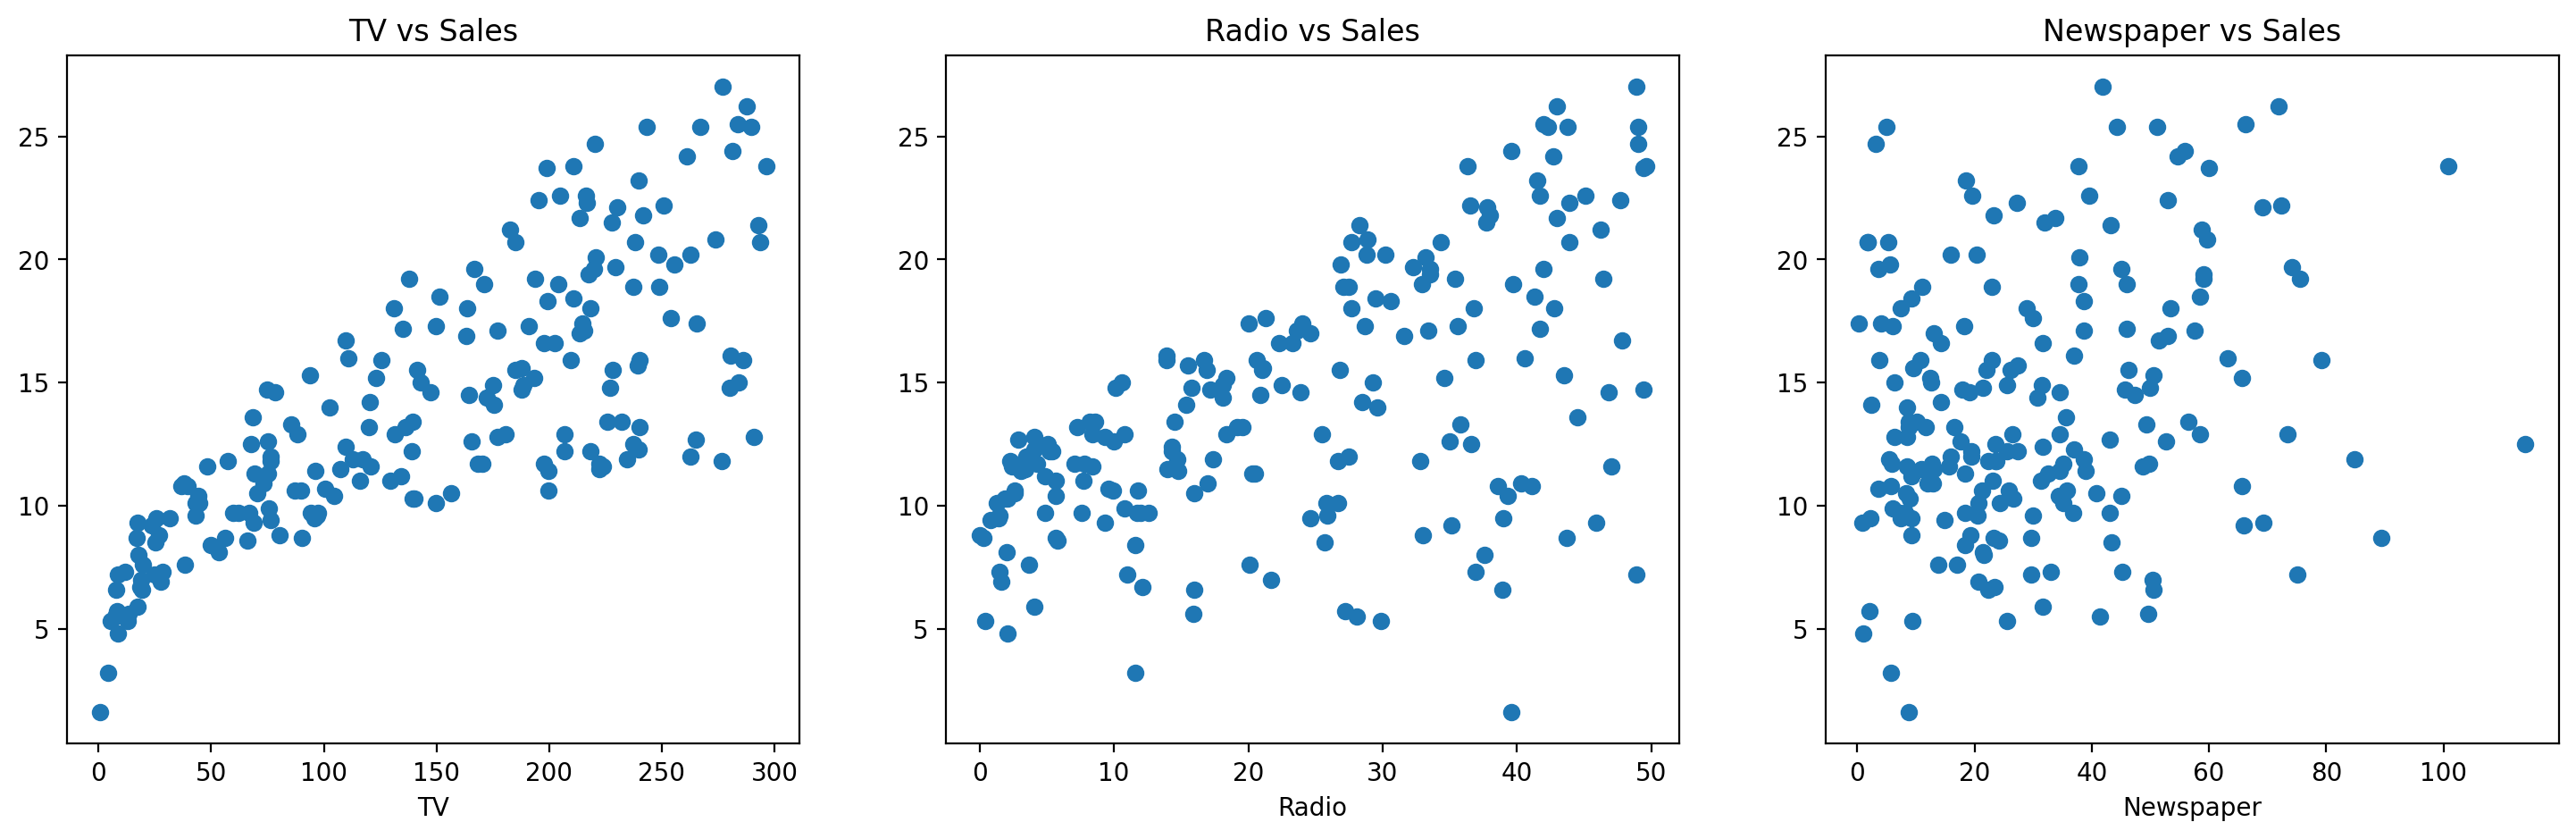

In [6]:
features = ['TV', 'Radio', 'Newspaper']
plt.figure(figsize=(18, 5))

for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1) 
    plt.scatter(data_full[feature], data_full['Sales'])
    plt.xlabel(feature)
    plt.title(f'{feature} vs Sales')
plt.show()

For now, I will drop the Newspaper column, primarily for visualization purposes. Since I plan to plot the data in 3D, using two features and one target variable, including a third feature would make it nearly imposiible to visualize, cause we can’t easily represent a 4D plot. Additionally, the Newspaper feature has a very low correlation, which suggests it contributes little to the predictive power of the model. However, I will include it later when building a multiple linear regression model with three features, where visualization is not the main focus, but accuracy is.

In [7]:
data = data_full.drop('Newspaper', axis = 1)

In [8]:
data

,TV,Radio,Sales
1,230.1,37.8,22.1
2,44.5,39.3,10.4
3,17.2,45.9,9.3
4,151.5,41.3,18.5
5,180.8,10.8,12.9
...,...,...,...
196,38.2,3.7,7.6
197,94.2,4.9,9.7
198,177.0,9.3,12.8
199,283.6,42.0,25.5


In [9]:
X = np.array(data[['TV', 'Radio']])

In [10]:
Y = np.array(data['Sales'])

Now I will split the dataset into training and test sets, using 20% of the data for testing, which corresponds to 40 rows, and the remaining 160 rows for training. When using scikit-learn, I encountered an issue related to the intercept term. In analytical methods like the closed-form solution using the normal equation, it’s important to explicitly add a column of ones to represent the intercept, and if we omit this column, the model will not learn the correct offset, and the accuracy will suffer. However, in scikit-learn, the intercept is handled automatically by default (with fit_intercept = True). If we manually add a column of ones and don’t adjust the fit_intercept, it may lead to incorrect results due to redundancy.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [12]:
X_train_ones = np.column_stack((np.ones(len(X_train)),np.array(X_train)))

###  General Matrix Formulation for Linear Least Squares
The process of finding the best coefficients that fit the data is the same as in the previous notebooks: we minimize the sum of squared residuals or errors. This means we compute the partial derivatives of the residual sum with respect to each coefficient, set them equal to zero, and solve the resulting system of linear equations known as the normal equations to find the best coefficients. However, it’s important to note that simple linear, polynomial, and multiple linear regression models all fall under the same general linear least squares model:

$$
{y} = a_0 x_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + ... + a_m z_m + e
$$
Using the matrix notation this expression can be expressed as 
$$
\mathbf{Y} = \mathbf{X} \mathbf{A} + \mathbf{E}
$$

where $\mathbf{X}$ is a matrix of the calculated values of the basis functions at the measured values of the independent variables,including a column of ones for the intercept.
$$
X =
\begin{bmatrix}
1 & x_{11} & x_{12} & \dots & x_{1m} \\
1 & x_{21} & x_{22} & \dots & x_{2m} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \dots & x_{nm}
\end{bmatrix}
$$
where n is the number of variables in the model and m is the number of data points. Because $m >= n + 1$, you should recognize that most of the time, $\mathbf{X}$ is not a square matrix.

The column vector $\mathbf{Y}$ contains the observed values of the dependent variable
$$
\mathbf{Y}^\top =
\begin{bmatrix}
y_1 & y_2 & \dots & y_m
\end{bmatrix}
$$
The column vector $\mathbf{A}$ contains the unknown coefficents
$$
\mathbf{A}^\top =
\begin{bmatrix}
a_0 & a_1 & \dots & y_n
\end{bmatrix}
$$
and the column vector $\mathbf{E}$ contains the residuals
$$
\mathbf{A}^\top =
\begin{bmatrix}
e_1 & e_2 & \dots & e_m
\end{bmatrix}
$$

The least squares solution minimizes the sum of squared residuals:
The sum of squared residuals is given by:

$$
S_r = \sum_{i=1}^{n} \left( y_i - \sum_{j=0}^{m} a_j x_{ij} \right)^2
$$
Or in matrix form:
$$
S_r = \| \mathbf{y} - \mathbf{X} \mathbf{A} \|^2
$$

$$
S_r = (\mathbf{y} - \mathbf{X}\mathbf{A})^\top(\mathbf{y} - \mathbf{X}\mathbf{A})
$$

$$
= \mathbf{y}^\top \mathbf{y} - 2\mathbf{y}^\top \mathbf{X}\mathbf{A} + \mathbf{A}^\top \mathbf{X}^\top \mathbf{X} \mathbf{A}
$$

Setting the gradient with respect to $\mathbf{A}$ to zero gives the normal equations:
$$
\nabla_{\mathbf{A}} S_r = -2\mathbf{X}^\top \mathbf{y} + 2\mathbf{X}^\top \mathbf{X} \mathbf{A}
$$

$$
-2\mathbf{X}^\top \mathbf{y} + 2\mathbf{X}^\top \mathbf{X} \mathbf{A} = 0
$$

$$
\mathbf{X}^\top \mathbf{X} \mathbf{A} = \mathbf{X}^\top \mathbf{y}
$$
Solving for $\mathbf{A}$ gives the closed-form solution:
$$
\mathbf{A} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

This is known as the **general least squares theorem**, and it applies to simple, multiple, and polynomial linear regression — as long as the model is linear in the parameters. 

In [13]:
A = np.linalg.inv(X_train_ones.T @ X_train_ones) @ (X_train_ones.T @ y_train)

In [14]:
A

array([3.02825525, 0.0447283 , 0.19066726])

In [15]:
model = LinearRegression()

In [16]:
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


As wee see the coefficients for the vector $\mathbf{A}$ are the same

In [17]:
model.coef_, model.intercept_

(array([0.0447283 , 0.19066726]), np.float64(3.0282552507833067))

In [18]:
y_pred = model.predict(X_test)

In [19]:
y_pred

array([16.35747252, 20.86299397, 21.52505848, 10.58719845, 22.22459614,
       13.06070499, 21.09564403,  7.47641062, 13.62409831, 15.15019438,
        9.12761147,  6.62878923, 14.16531076,  8.97073929,  9.66825463,
       12.12821691,  8.71252199, 16.30911498, 10.26684186, 18.89010391,
       19.4519532 , 13.03925601, 12.41182149, 21.20994137,  7.88771365,
        5.80255394, 20.7764401 , 12.02358305,  9.1784369 ,  8.59012258,
       12.46070487, 10.03213267, 21.34367738, 12.11632301, 18.23376459,
       20.22242395, 14.14999367, 20.78067544, 11.07322103,  4.56335118])

In [20]:
errors = y_pred - y_test

In [21]:
errors

array([-0.54252748, -1.53700603,  0.12505848,  3.28719845, -2.47540386,
        0.46070499, -1.20435597, -0.92358938,  2.12409831,  0.25019438,
       -0.37238853, -2.07121077,  2.26531076,  3.67073929, -0.63174537,
        0.42821691,  3.21252199, -0.29088502, -1.03315814, -0.00989609,
       -0.2480468 ,  0.53925601,  1.51182149, -0.99005863, -1.41228635,
       -2.29744606, -0.9235599 , -1.37641695, -1.4215631 ,  2.89012258,
        1.86070487, -1.26786733, -2.35632262,  3.41632301,  2.13376459,
       -0.47757605,  2.54999367, -0.01932456, -0.82677897, -2.33664882])

In [22]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Persentage Error: {MAPE:.5f}%")
print(f"Mean Absolute Error: {MAE:.5f}")
print(f"Root Mean Squared Error: {RMSE:.5f}")

Mean Absolute Persentage Error: 0.15090%
Mean Absolute Error: 1.44430
Root Mean Squared Error: 1.77143


Now that we have calculated the error metrics MAE, MAPE, and RMSE and all of them are around 1, we can say that the model performs very well. Therefore, we can proceed to the visualization step. Since our model has two features, we are fitting a regression plane (not a curve) to the data points in 3D space. To do this, I will use a plotly library. Below, you can see a visualization of the training data points, along with the regression plane that has been fitted to them.

In [23]:
x0 = np.array(data['TV'])
x1 = np.array(data['Radio'])
y = np.array(data['Sales'])

a2 = model.coef_[1]
a1 = model.coef_[0]
a0 = model.intercept_
 
x0_grid, x1_grid = np.meshgrid(
    np.linspace(x0.min(), x0.max(), 30),
    np.linspace(x1.min(), x1.max(), 30)
)
y_grid = a0 + a1 * x0_grid + a2 * x1_grid 

fig = go.Figure()

# Data points
fig.add_trace(go.Scatter3d(
    x = x0, y = x1, z = y, marker = dict(size = 3, color = 'red'),mode = 'markers', name = 'Data Points'
))

# Regression plane
fig.add_trace(go.Surface( 
    x = x0_grid, y = x1_grid, z = y_grid, opacity = 0.5, colorscale = 'Viridis', name = 'Regression Plane'
))

fig.update_layout(scene = dict(xaxis_title = 'TV', yaxis_title = 'Radio', zaxis_title = 'Sales'),
    title = 'Fitting a plane to data points',
    width = 1000,
    height = 700
)
fig.show()

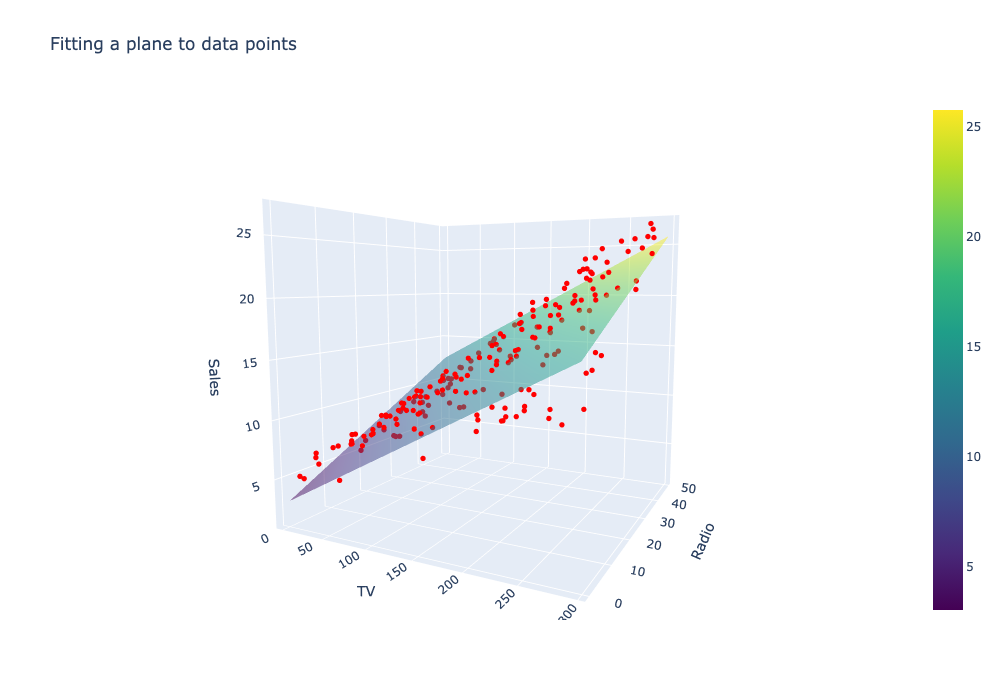

However, in some cases, it is also useful to visualize the test data points along with the model's predictions on the regression plane. This allows us to see how well the model generalizes to unseen data and to identify any outliers or problematic points that might negatively affect the model’s performance. The visualization below provides an intuitive understanding of how well the regression plane fits both the train and test data.

In [24]:
# Meshgrid for plotting the regression surface
x0_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
x1_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)
xy_grid = np.c_[x0_grid.ravel(), x1_grid.ravel()]
y_grid = model.predict(xy_grid).reshape(x0_grid.shape)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x = X_test[:, 0], y = X_test[:, 1], z = y_test, mode = 'markers', marker = dict(size = 5, color = 'green'), 
    name = 'Test Points'
))

fig.add_trace(go.Scatter3d(
    x = X_test[:, 0], y = X_test[:, 1], z = y_pred, mode = 'markers', marker = dict(size = 5, color = 'red'),
    name = 'Predicted Test Points'
))

fig.add_trace(go.Surface(
    x = x0_grid, y = x1_grid, z = y_grid, colorscale = 'viridis',opacity = 0.6, showscale = False,
    name = 'Regression Plane'
))


fig.update_layout( scene = dict(xaxis_title = 'TV', yaxis_title = 'Radio', zaxis_title = 'Sales'),
    title = 'Comparising the test and predicted points',
    width = 1000,
    height = 700
)

fig.show()

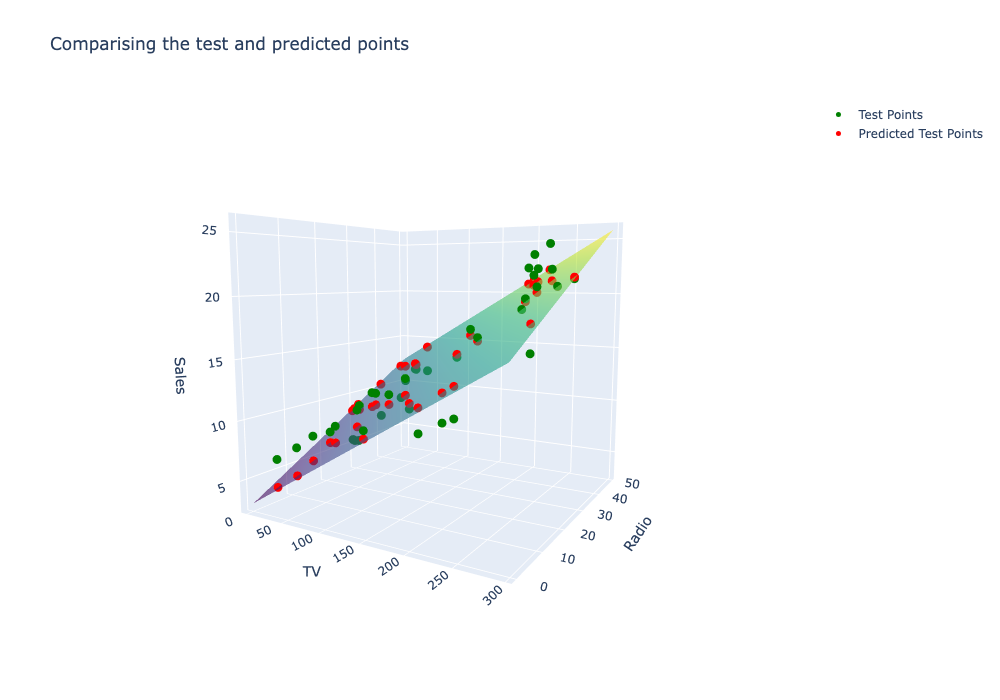

As we can see, the model performs well on both the training and test data points. Therefore, the next step is to train the model on the entire dataset in order to improve the overall performance and make use of all available information. By retraining the model on the full dataset, we can also compare the newly obtained coefficients with the previous ones (from the train-test split). As shown below, there is almost no difference between the coefficients. This indicates that the regression plane remains almost the same. The plot below shows the fitted plane over all data points, and we can observe how well it captures the overall trend in the data. However, it seems that a polynomial regression model may fit the data even better, especially if the underlying relationship is non-linear. In such cases, a curved surface (rather than a flat plane) might provide a more accurate fit.

In [25]:
model_2 = LinearRegression()

In [26]:
model_2.fit(X, Y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [27]:
model_2.coef_, model_2.intercept_

(array([0.04575482, 0.18799423]), np.float64(2.9210999124051362))

In [28]:
model.coef_, model.intercept_

(array([0.0447283 , 0.19066726]), np.float64(3.0282552507833067))

In [29]:
a2 = model_2.coef_[1]
a1 = model_2.coef_[0]
a0 = model_2.intercept_
 
x0_grid, x1_grid = np.meshgrid(
    np.linspace(x0.min(), x0.max(), 30),
    np.linspace(x1.min(), x1.max(), 30)
)
y_grid = a0 + a1 * x0_grid + a2 * x1_grid 

fig = go.Figure()

# Data points
fig.add_trace(go.Scatter3d(
    x = x0, y = x1, z = y, marker = dict(size = 3, color = 'red'),mode = 'markers', name = 'Data Points'
))

# Regression plane
fig.add_trace(go.Surface( 
    x = x0_grid, y = x1_grid, z = y_grid, opacity = 0.5, colorscale = 'Viridis', name = 'Regression Plane'
))

fig.update_layout(scene = dict(xaxis_title = 'TV', yaxis_title = 'Radio', zaxis_title = 'Sales'),
    title = 'Fitting a plane to data points',
    width = 1000,
    height = 700
)
fig.show()

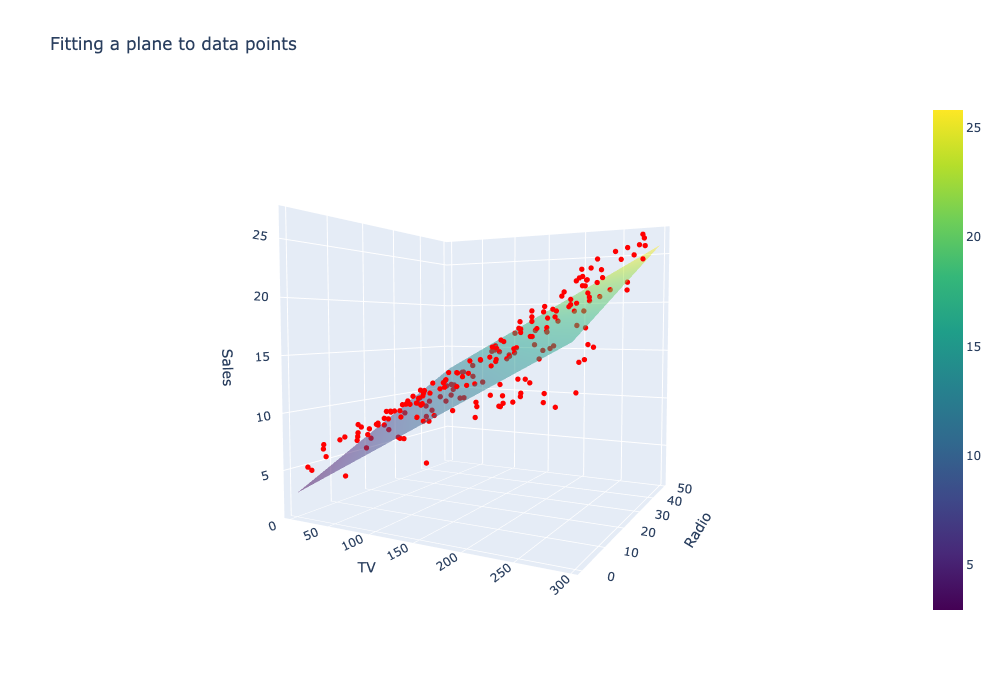

Finally, I will return to the original version of the dataset, which includes all three features: `TV`, `Radio`, and `Newspaper`. I will perform the general linear model to these features. As we will see, adding the `Newspaper` column introduces just one additional coefficient. However, the overall difference in the model’s performance and the values of the coefficients is not significant. This suggests that the additional feature does not drastically change the model’s behavior.

Based on the current observations, I believe the polynomial model will provide a better fit, since the relationship between the inputs and output may not be strictly linear.

In [30]:
model_final = LinearRegression()

In [31]:
model_final.fit(np.array(data_full.drop(['Sales'], axis = 1)), 
                np.array(data_full['Sales']))

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
model_final.coef_, model_final.intercept_

(array([ 0.04576465,  0.18853002, -0.00103749]),
 np.float64(2.9388893694594085))

In [33]:
model_2.coef_, model_2.intercept_

(array([0.04575482, 0.18799423]), np.float64(2.9210999124051362))

# References
[1] Numerical Methods for Engineers, Seventh Edition Steven C. Chapra, Raymond P. Canale

[2] https://www.kaggle.com/datasets/tawfikelmetwally/advertising-dataset